In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from tqdm import tqdm



In [2]:
# 設定隨機種子
seed_value = 421
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

# 確保在使用 CUDA 時的確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:
# 讀取資料
data = pd.read_excel('C:/Users/fishd/Desktop/Github/FTIR_dust/dataset/土壤DATA/訓練用/ALL_4000_750_881筆(未調).xlsx')



In [4]:
data.head()

,number,4000,3999,3998,3997,3996,3995,3994,3993,3992,...,755,754,753,752,751,750,TC(%),TOC(%),TN(%),TIC(%)
0,QGL_01_B1,84.331427,84.330130,84.328765,84.327574,84.326784,84.326553,84.326564,84.326125,84.324770,...,81.801612,81.876220,81.941196,81.995195,82.046126,82.103765,2.448957,2.433664,0.215523,0.015294
1,QGL_01_B3,82.338317,82.335726,82.333509,82.332317,82.332650,82.334393,82.336235,82.336610,82.334965,...,76.151623,76.277277,76.397989,76.514041,76.630463,76.752235,1.656626,1.638484,0.200913,0.018142
2,QGL_02_B1,100.076409,100.073643,100.073206,100.075266,100.078641,100.081250,100.081406,100.078833,100.075060,...,99.482538,99.494538,99.505582,99.518741,99.538745,99.567235,2.174914,2.157498,0.267499,0.017416
3,QGL_02_B3,96.065179,96.063129,96.062834,96.064748,96.067861,96.070091,96.069924,96.067626,96.065175,...,92.775779,92.818439,92.856857,92.900635,92.956427,93.024762,1.371313,1.355147,0.144839,0.016166
4,QGL_03_B1,91.450119,91.448253,91.448150,91.449619,91.452043,91.454286,91.455064,91.453903,91.451647,...,88.040093,88.089522,88.134861,88.183655,88.236933,88.296438,2.272914,2.257133,0.277246,0.015781


In [5]:
# 設定 TOC % 欄位名稱
toc_column = 'TOC(%)'

# 計算 IQR（四分位距）
Q1 = data[toc_column].quantile(0.25)
Q3 = data[toc_column].quantile(0.75)
IQR = Q3 - Q1

# 定義離群值範圍
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 過濾掉離群值
data_filtered = data[(data[toc_column] >= lower_bound) & (data[toc_column] <= upper_bound)]

# 顯示過濾後的資料
data_filtered.head()


,number,4000,3999,3998,3997,3996,3995,3994,3993,3992,...,755,754,753,752,751,750,TC(%),TOC(%),TN(%),TIC(%)
3,QGL_02_B3,96.065179,96.063129,96.062834,96.064748,96.067861,96.070091,96.069924,96.067626,96.065175,...,92.775779,92.818439,92.856857,92.900635,92.956427,93.024762,1.371313,1.355147,0.144839,0.016166
5,QGL_03_B3,94.700743,94.700373,94.696905,94.692026,94.687820,94.685177,94.684080,94.684185,94.685179,...,92.693115,92.718762,92.734258,92.751812,92.788583,92.852711,1.522045,1.508612,0.178382,0.013433
7,QGL_04_B3,93.312401,93.311351,93.310250,93.309303,93.308666,93.308442,93.308419,93.308102,93.307113,...,91.196523,91.257505,91.307615,91.345884,91.379988,91.417461,1.007062,0.993129,0.113674,0.013933
8,QGL_05_B1,85.000735,84.999285,84.997725,84.996506,84.996158,84.996752,84.997410,84.996893,84.994611,...,81.180209,81.270977,81.351662,81.422503,81.493677,81.574501,1.517121,1.501415,0.189652,0.015706
9,QGL_05_B3,85.471304,85.468531,85.466190,85.465185,85.466211,85.469134,85.472561,85.474631,85.474434,...,76.171990,76.358026,76.537399,76.708127,76.881318,77.064747,1.065553,1.052031,0.105813,0.013522


In [6]:
# 分離舊資料與新資料
old_data = data_filtered.iloc[:, 1:-4]
old_data.head()

,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,759,758,757,756,755,754,753,752,751,750
3,96.065179,96.063129,96.062834,96.064748,96.067861,96.070091,96.069924,96.067626,96.065175,96.064357,...,92.531790,92.594322,92.659819,92.722478,92.775779,92.818439,92.856857,92.900635,92.956427,93.024762
5,94.700743,94.700373,94.696905,94.692026,94.687820,94.685177,94.684080,94.684185,94.685179,94.686981,...,92.577600,92.596631,92.622801,92.657779,92.693115,92.718762,92.734258,92.751812,92.788583,92.852711
7,93.312401,93.311351,93.310250,93.309303,93.308666,93.308442,93.308419,93.308102,93.307113,93.305391,...,91.000439,91.040290,91.082240,91.134681,91.196523,91.257505,91.307615,91.345884,91.379988,91.417461
8,85.000735,84.999285,84.997725,84.996506,84.996158,84.996752,84.997410,84.996893,84.994611,84.991120,...,80.861344,80.930445,81.003951,81.088116,81.180209,81.270977,81.351662,81.422503,81.493677,81.574501
9,85.471304,85.468531,85.466190,85.465185,85.466211,85.469134,85.472561,85.474631,85.474434,85.472533,...,75.550383,75.687437,75.831835,75.993065,76.171990,76.358026,76.537399,76.708127,76.881318,77.064747


In [7]:
# 分離舊資料與新資料
new_data = data_filtered.iloc[-1, 1:-4]

# 對資料進行標準化
scaler = StandardScaler()
old_data_scaled = scaler.fit_transform(old_data)
new_data_scaled = scaler.transform(new_data.values.reshape(1, -1))

# 使用 PCA 進行降維
pca = PCA(n_components=100)
X_pca = pca.fit_transform(old_data_scaled)
new_pca = pca.transform(new_data_scaled)



In [8]:
# 目標變量
target = data_filtered.iloc[:, -3]
print(target.head())
# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.2, random_state=seed_value)

# 將資料轉換為 PyTorch Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# 調整輸入形狀以適應 CNN 模型
X_train_tensor = X_train_tensor.unsqueeze(1)  # 增加 channel 維度
X_test_tensor = X_test_tensor.unsqueeze(1)  # 增加 channel 維度

# 設定 DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



3    1.355147
5    1.508612
7    0.993129
8    1.501415
9    1.052031
Name: TOC(%), dtype: float64


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定義帶 ResNet 概念的 CNN 模型
class ResCNNRegressor(nn.Module):
    def __init__(self, input_shape):
        super(ResCNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # 殘差連接中的額外卷積層（確保維度一致）
        self.res_conv = nn.Conv1d(32, 64, kernel_size=1)  # 1x1 卷積
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        # 第一層卷積和池化
        x1 = self.conv1(x)
        x1 = torch.relu(x1)
        x1 = self.pool1(x1)

        # 第二層卷積 + 殘差連接
        residual = self.res_conv(x1)  # 經過1x1卷積調整通道數
        x2 = self.conv2(x1)
        x2 = torch.relu(x2)
        x2 = x2 + residual  # 加上殘差
        x2 = self.pool2(x2)

        # 全連接層部分
        x2 = self.flatten(x2)
        x2 = torch.relu(self.fc1(x2))
        x2 = torch.relu(self.fc2(x2))
        x2 = torch.relu(self.fc3(x2))
        x2 = self.fc4(x2)
        return x2

# 訓練配置
input_shape = X_train_tensor.shape[1]
model = ResCNNRegressor(input_shape).to(device)
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


In [10]:
from torchinfo import summary
summary(model, device=device)

Layer (type:depth-idx)                   Param #
ResNet1D                                 --
├─Conv1d: 1-1                            448
├─BatchNorm1d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool1d: 1-4                         --
├─Sequential: 1-5                        --
│    └─ResidualBlock1D: 2-1              --
│    │    └─Conv1d: 3-1                  12,288
│    │    └─BatchNorm1d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv1d: 3-4                  12,288
│    │    └─BatchNorm1d: 3-5             128
│    └─ResidualBlock1D: 2-2              --
│    │    └─Conv1d: 3-6                  12,288
│    │    └─BatchNorm1d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv1d: 3-9                  12,288
│    │    └─BatchNorm1d: 3-10            128
├─Sequential: 1-6                        --
│    └─ResidualBlock1D: 2-3              --
│    │    └─Conv1d: 3-11                 24,576
│

In [11]:
# 訓練模型
epochs = 2000
epochs = 2000
model.train()
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc=f"Train epochs {epochs}"):
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.flatten(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 驗證損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.flatten(), y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    model.train()

# 評估模型
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor.to(device)).cpu().numpy().flatten()
    y_pred_test = model(X_test_tensor.to(device)).cpu().numpy().flatten()

train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f'train MSE: {train_mse}, train R²: {train_r2}')
print(f'test MSE: {test_mse}, test R²: {test_r2}')



Train epochs 2000: 100%|██████████| 2000/2000 [01:34<00:00, 21.27it/s]

train MSE: 0.002797322283032714, train R²: 0.9805389818948921
test MSE: 0.054911186683496815, test R²: 0.6152391570740869


In [12]:
y_pred_train = model(X_train_tensor.to(device)).cpu().detach().numpy().flatten()
y_pred_test = model(X_test_tensor.to(device)).cpu().detach().numpy().flatten()

print("y_pred_train shape:", y_pred_train.shape)  # 應該是 (704,)


y_pred_train shape: (655,)


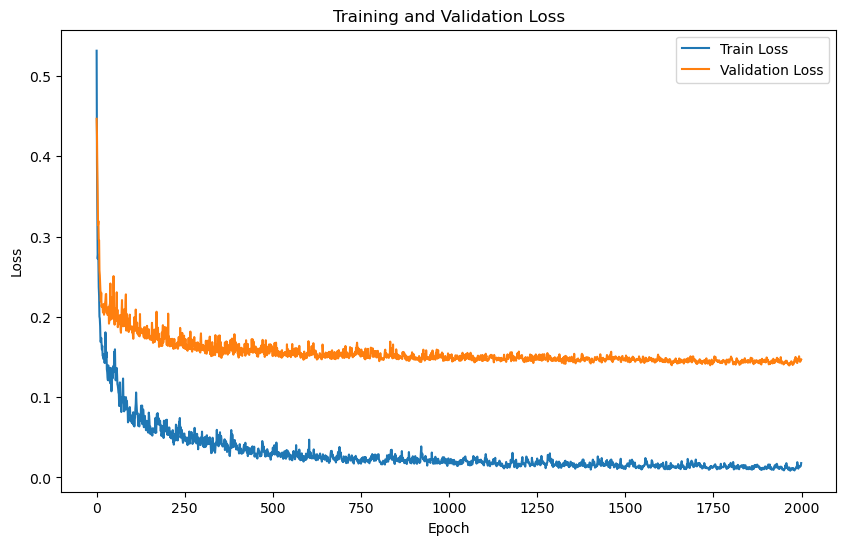

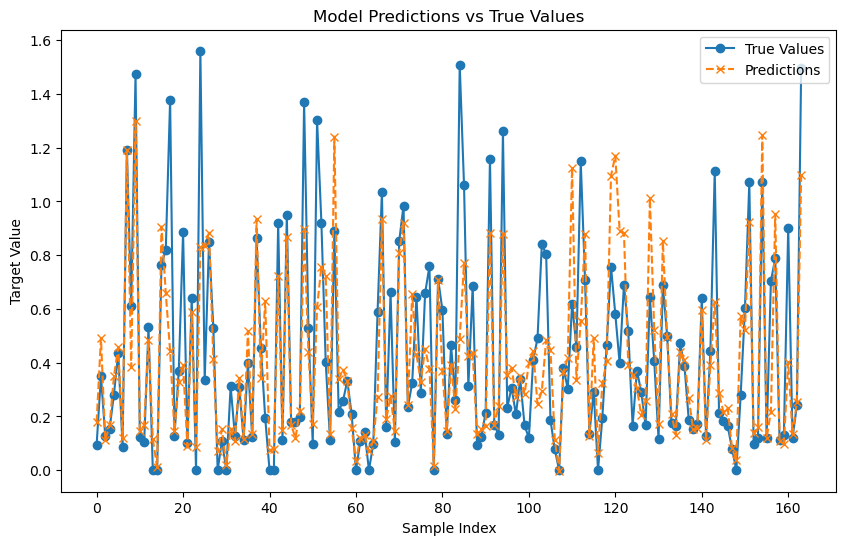

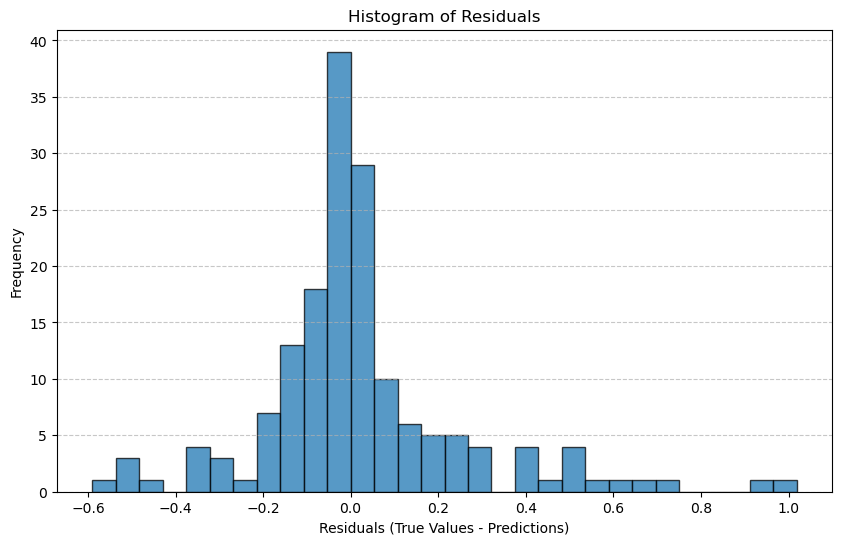

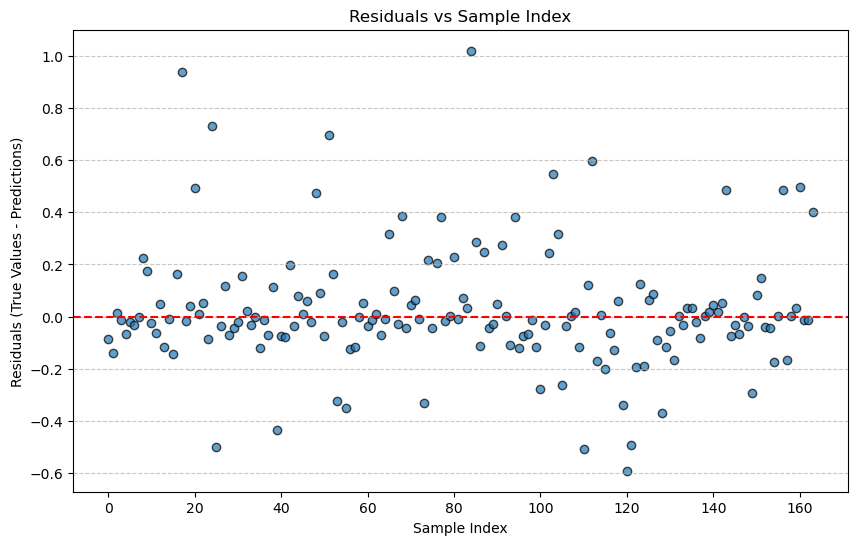

In [13]:
# 繪製訓練和驗證損失曲線
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# 繪製預測結果與真實值的比較
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values', marker='o')
plt.plot(y_pred_test, label='Predictions', linestyle='--', marker='x')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Model Predictions vs True Values')
plt.show()


# 計算差值（實際值減去預測值）
residuals = y_test.values - y_pred_test

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.75, edgecolor='black')
plt.xlabel('Residuals (True Values - Predictions)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 計算誤差（Residuals）
residuals = y_test.values - y_pred_test

# 繪製散點圖
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.7, edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)  # 繪製基準線 y=0
plt.xlabel('Sample Index')
plt.ylabel('Residuals (True Values - Predictions)')
plt.title('Residuals vs Sample Index')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [14]:
# 使用模型對新資料進行預測
model.eval()  # 設置模型為推論模式（evaluation mode）
X_new_tensor = torch.tensor(new_pca, dtype=torch.float32).unsqueeze(0).to(device)  # 增加 batch 維度
with torch.no_grad():  # 關閉梯度計算
    prediction = model(X_new_tensor).cpu().numpy().flatten()

print("Prediction for new data:", prediction[0])
print('True Value:', data.iloc[-1, -4])


Prediction for new data: 0.88257736
True Value: 0.984
